In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 10]

import warnings
warnings.filterwarnings("ignore")

In [41]:
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, MDS
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from bs4 import BeautifulSoup

def preprocess(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

In [4]:
# load and randomize

yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=1.)
movies = pd.read_csv('sentiment/movies.csv').sample(frac=1.)

## Inspecting p(X) of the BOW vectorizers

Assuming that our data consists of discrete features, as in the Bag of Words models we have seen so far, visualizing $p(X)$ consists of visualizing the PMF of a multionomial distribution that consists of all the features in our data. 

Of course, this is a very wide distribution, even if we just include unigrams. 

Thus, we will visualize just the most popular features. 

We will see how, given the most popular features of one dataset, the other dataset compares. 

In [5]:
from copy import deepcopy

def _train_and_transform(vectorizer, X):
    vectorizer.fit(X)
    return vectorizer, vectorizer.transform(X)

def compare(vectorizer, A, B):
    vec_A, VA = _train_and_transform(deepcopy(vectorizer), A) 
    vec_B, VB = _train_and_transform(deepcopy(vectorizer), B) 

    # Get the most popular words for A
    # ignoring the top 25 super common
    # words
    sums = np.array(VA.sum(0)).reshape(-1)
    tops = np.argsort(sums)[-325:-25]
    freqs_A = sums[tops]

    features = np.array(vec_A.get_feature_names())[tops]

    idxs = np.array([vec_B.vocabulary_.get(s) for s in features])
    sums = np.array(VB.sum(0)).reshape(-1)
    freqs_B = [sums[i] if i else 0. for i in idxs]

    return pd.concat([pd.DataFrame({ 'word': features, 'dataset': d, 'freq': f }) 
                      for d,f in [('A',freqs_A), ('B',freqs_B)]])

In [6]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 1, use_idf=False)
df = compare(vectorizer, yelps.sample(500).text, movies.sample(500).text)

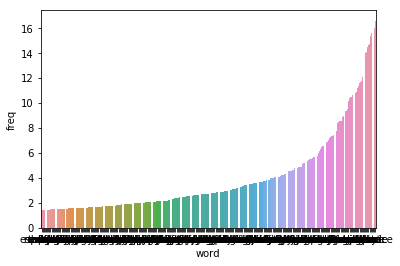

In [7]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'A'])

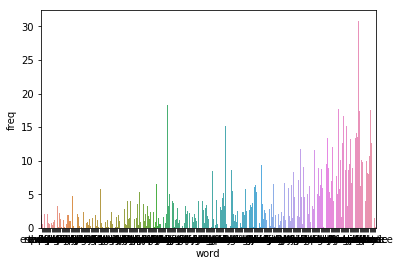

In [8]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'B'])

## Generative vs. Discriminative

Play around with the following plotting function. Is this consisten with the theoretical results of Ng and Jordan? Can you get the opposite results? Why? 

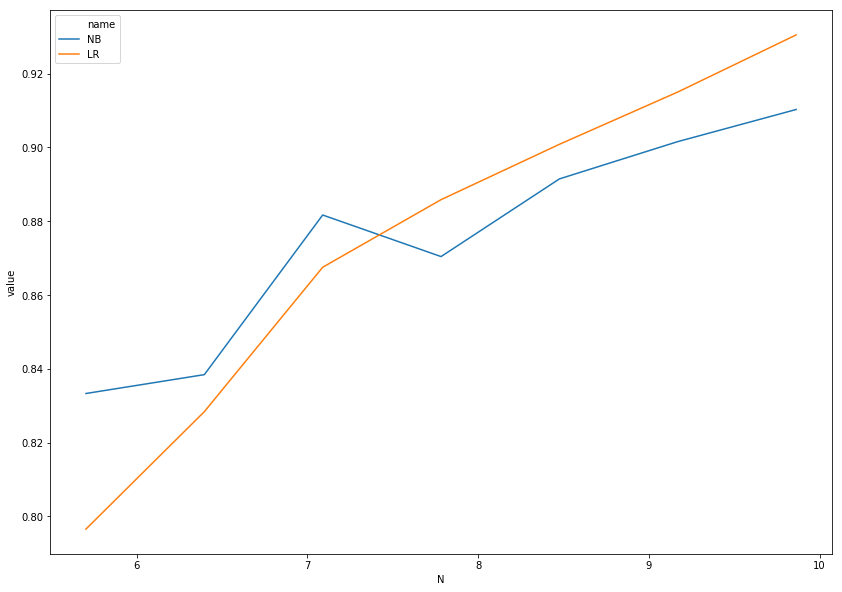

In [12]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 20, use_idf=False)
V = vectorizer.fit_transform(yelps.text)
y = yelps.positive

def _cv_score(V, y, models):
    return [{ 'name': name, 'value': np.mean(cross_val_score(model, V, y, cv=3)) }
            for name, model in models]

def plot_cv_scores(V, y, models, ticks):
    scores = [_cv_score(V[:t], y[:t], models) for t in ticks]        
    scores = [({'N': np.log(t) , **i}) for t,s 
              in zip(ticks, scores) for i in s]
    df = pd.DataFrame(scores)
    return sns.lineplot(y='value', x='N', hue='name', data=df)

models = [('NB', MultinomialNB(fit_prior=False)), 
          ('LR', LogisticRegression())]

plot_cv_scores(V, y, models, [300, 600, 1200, 2400, 4800, 9600, 19200])

# Resutlts are consisten with NG and Jordan.

## Searching the Grid

Hyperparameter tuning, in its simplest form, can be done via a grid search. 

We can use cross validation to estimate the out-of-sample expected risk. 

SKlearn gives us a very nice package for this: GridSearchCV

The API can be a bit complicated at first glance, but it's simple once you get used to it and comfortable with the idea of a "pipeline". 

In [15]:
# Multinomial NB
classifier_NB = MultinomialNB()
parameters_NB = {'alpha' : np.linspace(0.5, 1.5, 6),'fit_prior': [True, False]}
cv_NB         = GridSearchCV(classifier_NB, parameters_NB, cv = 5, return_train_score=True)     

# Logistic Regression
classifier_LR = LogisticRegression()
parameters_LR = {'C':np.logspace(0, 4, 10), "penalty":["l1","l2"]}
cv_LR         = GridSearchCV(classifier_LR, parameters_LR, cv = 5, return_train_score=True) 

## Crosstraining

Test how well your model, when trained on one dataset, performs on the other. 

To do this, make sure that you: 

1. You perform the "fitting" of both the vectorizer and the model on one of the sets
2. Use the "transform" of the vectorizer to transform the second dataset into the same feature space (X) that your model was trained on. 
3. Use the "predict" of your model to see how well it did on the second dataset. 

How well does your model generalize from one to the other? What does this say about "sentiment"? 

In [18]:
# Perform this on a smaller sample of the data to not break your machine
yelps = yelps.sample(10000)
movies = movies.sample(10000)

# TfidfVectorizer
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 1, use_idf=False)

# Fit and transform the model on yelps
train = vectorizer.fit_transform(yelps['text'])

# Transform the model on movies 
test = vectorizer.transform(movies['text'])

In [21]:
'''GridSearchCV on train'''
# GridSearchCV Multinomial NB 
cv_NB.fit(train, yelps.positive)

# GridSearchCV for Logistic Regression
cv_LR.fit(train, yelps.positive)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e+00, 2.78256e+00, 7.74264e+00, 2.15443e+01, 5.99484e+01,
       1.66810e+02, 4.64159e+02, 1.29155e+03, 3.59381e+03, 1.00000e+04]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [40]:
'''Best model'''
# NB
print ("Best NB model: %r \n   with score: %r \n\n"  %(cv_NB.best_estimator_, cv_NB.best_score_))

# Logistic
print ("Best LR model: %r \n   with score: %r"  %(cv_LR.best_estimator_, cv_LR.best_score_))

Best NB model: MultinomialNB(alpha=0.5, class_prior=None, fit_prior=False) 
   with score: 0.9129 


Best LR model: LogisticRegression(C=166.81005372000593, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False) 
   with score: 0.9506


Comment: Logistic Regression performs better in sample. 

In [45]:
'''Predicting test data, using the best model of train'''
pred_NB  = cv_NB.predict(test) # NB predict test
pred_LR  = cv_LR.predict(test) # LR predict test

# # let's test accuracy
# print('NB:',metrics.accuracy_score(movies.positive, pred_nb))
# print()
# print('LR:',metrics.accuracy_score(movies.positive, pred_lr))
# print()
# print('SVM:',metrics.accuracy_score(movies.positive, pred_svm))

In [ ]:
print('NB:',metrics.confusion_matrix(movies.positive, pred_nb, labels=[0,1]))

In [68]:
'''Accuracy metrics'''
def accuracy_metrics(model_predict):
    # Confusion matrix
    conf_matrix = pd.DataFrame(metrics.confusion_matrix(movies.positive, model_predict))
    sns.heatmap(conf_matrix, annot=True,annot_kws={"size": 16}, cmap='Blues', fmt='g')
    plt.show()

    # Classification Report
    target_names = ['negative', 'positive']
    report = metrics.classification_report(movies.positive, model_predict, target_names = target_names)
    print(report)

    # Acccuracy
    accuracy = metrics.accuracy_score(movies.positive, model_predict)
    print("Accuracy: ", accuracy)

    # AUC and ROC Curve
    fpr, tpr, thresholds = metrics.roc_curve(movies.positive, model_predict)  
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')  
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

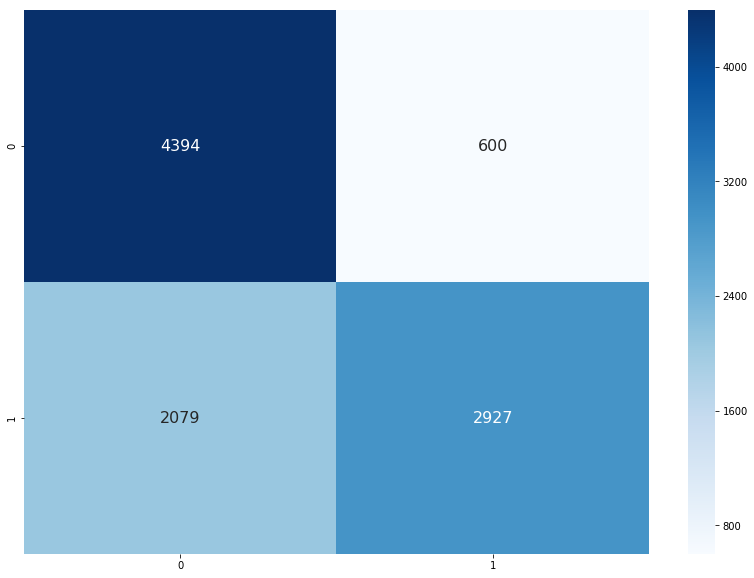

              precision    recall  f1-score   support

    negative       0.68      0.88      0.77      4994
    positive       0.83      0.58      0.69      5006

   micro avg       0.73      0.73      0.73     10000
   macro avg       0.75      0.73      0.73     10000
weighted avg       0.75      0.73      0.73     10000

Accuracy:  0.7321


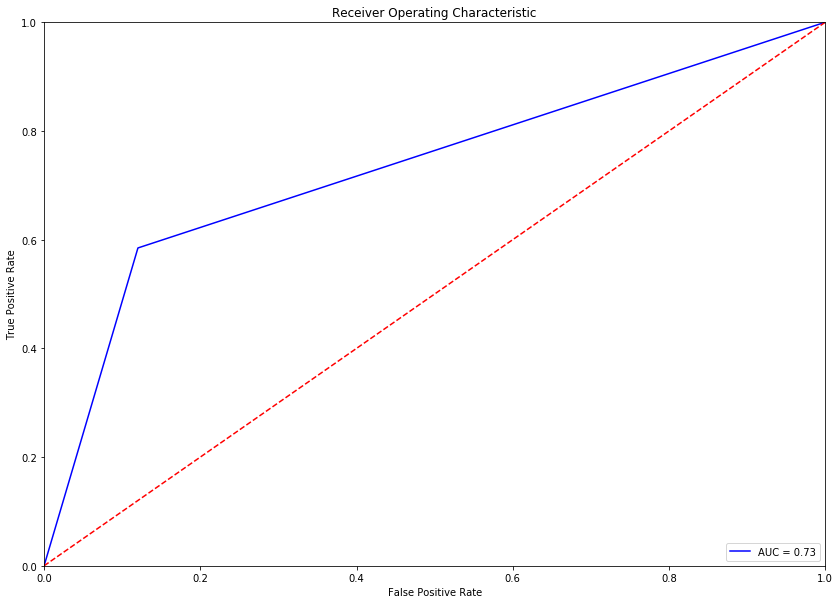

In [69]:
'''Accuracy Metrics - NB'''
accuracy_metrics(pred_NB)

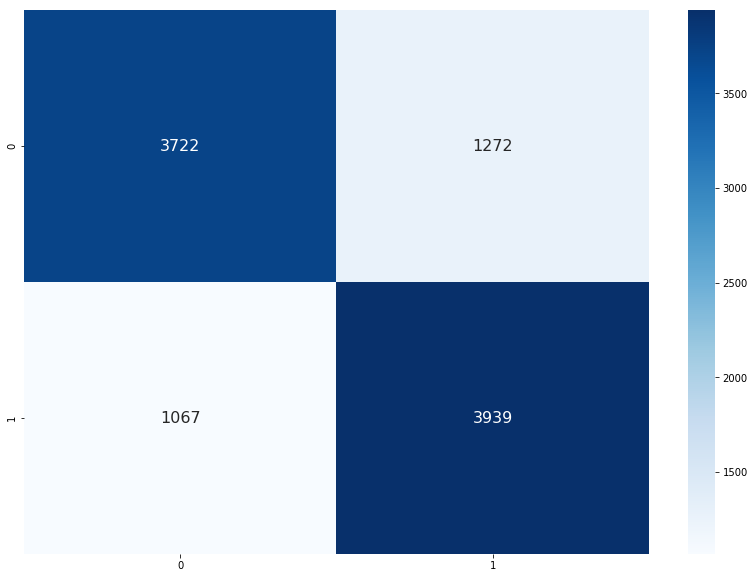

              precision    recall  f1-score   support

    negative       0.78      0.75      0.76      4994
    positive       0.76      0.79      0.77      5006

   micro avg       0.77      0.77      0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

Accuracy:  0.7661


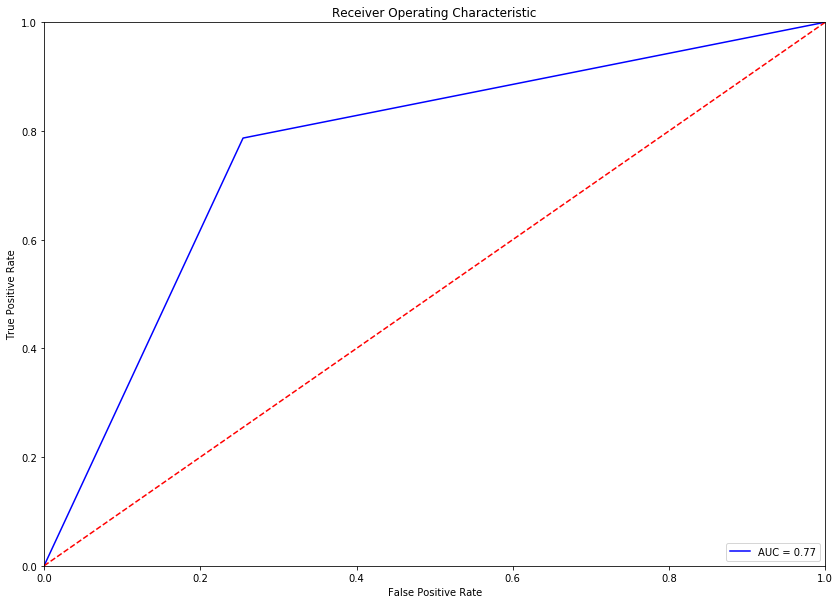

In [70]:
'''Accuracy Metrics - LR'''
accuracy_metrics(pred_LR)

Comment: When using the test data we get, as we expected, quite smaller accuracy. 
         However, LR still performs better. 